In [63]:
# Build gallery-style JSON from annos (with category_id)
import os
import json
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models, transforms
import faiss
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import random

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
random.seed(43)
torch.manual_seed(43)
np.random.seed(43)

class FashionRetrievalModel(nn.Module):
    def __init__(self, embedding_dim=512, num_classes=13):  # <-- now accepts num_classes
        super().__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.embedding = nn.Sequential(
            nn.Linear(num_ftrs, embedding_dim),
            nn.BatchNorm1d(embedding_dim),
        )

        self.classifier = nn.Linear(embedding_dim, num_classes)  # <-- new classifier head

    def forward(self, x):
        features = self.backbone(x)
        embed = F.normalize(self.embedding(features), p=2, dim=1)
        logits = self.classifier(embed)
        return embed, logits



In [64]:
#Triplet Dataset

In [65]:
class TripletFashionDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, annotation_path, annos_folder, transform):
        self.image_folder = image_folder
        self.annotation_path = annotation_path
        self.annos_folder = annos_folder
        self.transform = transform

        print(f"📂 Loading annotations from: {annotation_path}")
        with open(annotation_path) as f:
            self.data = json.load(f)

        self.category_to_images = {}
        for item in self.data:
            gallery_id = item.get("gallery_image_id")
            pair_id = item.get("pair_id")
            if gallery_id is not None and pair_id is not None:
                file_name = f"{gallery_id:06d}.jpg"
                full_path = os.path.join(image_folder, file_name)
                if os.path.isfile(full_path):
                    self.category_to_images.setdefault(pair_id, []).append(file_name)

        self.image_triplets = self._generate_triplets()
        print(f"✅ Triplets generated: {len(self.image_triplets)}")

    def _load_and_crop(self, filename):
        img_path = os.path.join(self.image_folder, filename)
        ann_path = os.path.join(self.annos_folder, filename.replace('.jpg', '.json'))
        img = Image.open(img_path).convert("RGB")
        if os.path.isfile(ann_path):
            with open(ann_path) as f:
                ann = json.load(f)
                if "bounding_box" in ann:
                    x, y, w, h = ann["bounding_box"]
                    img = img.crop((x, y, x + w, y + h))
        return img

    def _generate_triplets(self):
        triplets = []
        categories = list(self.category_to_images.keys())
        for cat in categories:
            imgs = self.category_to_images[cat]
            if len(imgs) < 2:
                continue
            for i in range(len(imgs) - 1):
                anchor = imgs[i]
                positive = imgs[i + 1]
                neg_cat = random.choice([c for c in categories if c != cat and len(self.category_to_images[c]) > 0])
                negative = self.category_to_images[neg_cat][0]
                triplets.append((anchor, positive, negative))
        return triplets

    def __len__(self):
        return len(self.image_triplets)

    def __getitem__(self, idx):
        a, p, n = self.image_triplets[idx]
        a_img = self._load_and_crop(a)
        p_img = self._load_and_crop(p)
        n_img = self._load_and_crop(n)
        if self.transform:
            a_img = self.transform(a_img)
            p_img = self.transform(p_img)
            n_img = self.transform(n_img)
        return a_img, p_img, n_img



In [66]:
#Training Loop

In [67]:
def train(model, dataloader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for i, (anchor, positive, negative) in enumerate(dataloader):
            anchor, positive, negative = anchor.to(DEVICE), positive.to(DEVICE), negative.to(DEVICE)
            a_embed, _ = model(anchor)
            p_embed, _ = model(positive)
            n_embed, _ = model(negative)

            loss = criterion(a_embed, p_embed, n_embed)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if i % 10 == 0:
                print(f"Epoch {epoch+1} | Batch {i}/{len(dataloader)} | Loss: {loss.item():.4f}")

        avg_loss = total_loss / len(dataloader)
        print(f"✅ Epoch {epoch+1} complete | Avg Loss: {avg_loss:.4f}")

In [68]:
image_folder = "validation/validation/image"
annotation_path = "val_annotations/json_for_validation/val_gallery.json"
annos_folder = "validation/validation/annos"

train_dataset = TripletFashionDataset(image_folder, annotation_path, annos_folder, transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

model = FashionRetrievalModel(num_classes=13).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.TripletMarginLoss(margin=0.3)

train(model, train_loader, optimizer, criterion, epochs=5)


📂 Loading annotations from: val_annotations/json_for_validation/val_gallery.json
✅ Triplets generated: 34682
Epoch 1 | Batch 0/2168 | Loss: 0.0377
Epoch 1 | Batch 10/2168 | Loss: 0.0435
Epoch 1 | Batch 20/2168 | Loss: 0.0277
Epoch 1 | Batch 30/2168 | Loss: 0.0253
Epoch 1 | Batch 40/2168 | Loss: 0.0225
Epoch 1 | Batch 50/2168 | Loss: 0.0436
Epoch 1 | Batch 60/2168 | Loss: 0.0388
Epoch 1 | Batch 70/2168 | Loss: 0.1012
Epoch 1 | Batch 80/2168 | Loss: 0.0106
Epoch 1 | Batch 90/2168 | Loss: 0.0172
Epoch 1 | Batch 100/2168 | Loss: 0.0212
Epoch 1 | Batch 110/2168 | Loss: 0.0338
Epoch 1 | Batch 120/2168 | Loss: 0.0101
Epoch 1 | Batch 130/2168 | Loss: 0.0415
Epoch 1 | Batch 140/2168 | Loss: 0.0353
Epoch 1 | Batch 150/2168 | Loss: 0.0177
Epoch 1 | Batch 160/2168 | Loss: 0.0285
Epoch 1 | Batch 170/2168 | Loss: 0.0379
Epoch 1 | Batch 180/2168 | Loss: 0.0028
Epoch 1 | Batch 190/2168 | Loss: 0.0157
Epoch 1 | Batch 200/2168 | Loss: 0.0000
Epoch 1 | Batch 210/2168 | Loss: 0.0112
Epoch 1 | Batch 220/21

In [81]:
class ClassificationFashionDataset(Dataset):
    def __init__(self, image_folder, annos_folder, json_path, transform=None):
        self.image_folder = image_folder
        self.annos_folder = annos_folder
        self.transform = transform
        self.data = []

        with open(json_path) as f:
            raw_data = json.load(f)

        for item in raw_data:
            image_id = item['gallery_image_id']
            file_name = f"{image_id:06d}.jpg"
            image_path = os.path.join(image_folder, file_name)
            ann_path = os.path.join(annos_folder, file_name.replace(".jpg", ".json"))

            if os.path.isfile(image_path) and os.path.isfile(ann_path):
                with open(ann_path) as f_ann:
                    ann = json.load(f_ann)
                    # Search inside item1 or item2
                    for key in ['item1', 'item2']:
                        if key in ann and 'category_id' in ann[key]:
                            cat_id = ann[key]['category_id']
                            self.data.append((image_path, cat_id - 1))  # category index starts from 0
                            break

        print("✅ Classification samples loaded:", len(self.data))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert("RGB")

        # Crop using bounding box if available
        ann_path = os.path.join(self.annos_folder, os.path.basename(img_path).replace(".jpg", ".json"))
        if os.path.isfile(ann_path):
            with open(ann_path) as f:
                ann = json.load(f)
                for key in ['item1', 'item2']:
                    if key in ann and "bounding_box" in ann[key]:
                        x, y, w, h = ann[key]["bounding_box"]
                        img = img.crop((x, y, x + w, y + h))
                        break

        if self.transform:
            img = self.transform(img)

        return img, label


In [82]:
cls_dataset = ClassificationFashionDataset(
    image_folder=image_folder,
    annos_folder=annos_folder,
    json_path=annotation_path,
    transform=transform
)

cls_loader = DataLoader(cls_dataset, batch_size=32, shuffle=True, drop_last=True)

✅ Classification samples loaded: 36961


In [84]:
#training classifier here
# 1) Define criterion and optimizer for classifier parameters only
clf_criterion = nn.CrossEntropyLoss()
clf_optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)

# 2) Put model in train mode
model.train()

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (imgs, labels) in enumerate(cls_loader):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        embeds, logits = model(imgs)  

        # Compute classification loss
        loss = clf_criterion(logits, labels)

        # Backward + step
        clf_optimizer.zero_grad()
        loss.backward()
        clf_optimizer.step()

        # Statistics
        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        if (i + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] "
                  f"Step [{i+1}/{len(cls_loader)}] "
                  f"Loss: {loss.item():.4f}")

    epoch_loss = running_loss / total
    epoch_acc  = correct / total * 100
    print(f"✅ Epoch {epoch+1} Complete — "
          f"Avg Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.1f}%\n")

Epoch [1/10] Step [50/1155] Loss: 1.4698
Epoch [1/10] Step [100/1155] Loss: 1.5831
Epoch [1/10] Step [150/1155] Loss: 1.6534
Epoch [1/10] Step [200/1155] Loss: 1.4021
Epoch [1/10] Step [250/1155] Loss: 1.3649
Epoch [1/10] Step [300/1155] Loss: 1.5241
Epoch [1/10] Step [350/1155] Loss: 1.4884
Epoch [1/10] Step [400/1155] Loss: 1.7981
Epoch [1/10] Step [450/1155] Loss: 1.5125
Epoch [1/10] Step [500/1155] Loss: 1.4505
Epoch [1/10] Step [550/1155] Loss: 1.3851
Epoch [1/10] Step [600/1155] Loss: 1.5597
Epoch [1/10] Step [650/1155] Loss: 1.6483
Epoch [1/10] Step [700/1155] Loss: 1.5569
Epoch [1/10] Step [750/1155] Loss: 1.4837
Epoch [1/10] Step [800/1155] Loss: 1.2756
Epoch [1/10] Step [850/1155] Loss: 1.4539
Epoch [1/10] Step [900/1155] Loss: 1.3676
Epoch [1/10] Step [950/1155] Loss: 1.5719
Epoch [1/10] Step [1000/1155] Loss: 1.8441
Epoch [1/10] Step [1050/1155] Loss: 1.5363
Epoch [1/10] Step [1100/1155] Loss: 1.7216
Epoch [1/10] Step [1150/1155] Loss: 1.2975
✅ Epoch 1 Complete — Avg Loss: 

In [142]:
# Build FAISS index using validation data with bounding box crop and category mapping

def crop_and_embed(image_path, annos_folder, model):
    img = Image.open(image_path).convert("RGB")
    ann_path = os.path.join(annos_folder,
                            os.path.basename(image_path).replace('.jpg', '.json'))
    if os.path.isfile(ann_path):
        with open(ann_path) as f:
            ann = json.load(f)
            for key in ['item1', 'item2']:
                if key in ann and "bounding_box" in ann[key]:
                    x, y, w, h = ann[key]["bounding_box"]
                    img = img.crop((x, y, x + w, y + h))
                    break

    img = transform(img).unsqueeze(0).to(DEVICE)
    model.eval()
    with torch.no_grad():
        emb, _ = model(img)      # ← take only the embedding
        return emb.cpu().numpy()


def build_faiss_index(image_folder, annos_folder, json_path, model, transform, label_json_path):
    import faiss
    import os
    import torch
    import json
    from tqdm import tqdm
    import numpy as np
    from PIL import Image

    # Load annotations with cls labels
    with open(label_json_path, "r") as f:
        anno_data = json.load(f)

    # Build a mapping from image ID to class
    id_to_cls = {item["image_id"]: item["cls"] for item in anno_data if "cls" in item}

    index = faiss.IndexFlatL2(512)  # dimension must match embedding size
    image_paths = []
    labels = []

    model.eval()

    for fname in tqdm(sorted(os.listdir(image_folder))):
        if not fname.endswith(".jpg"):
            continue

        img_path = os.path.join(image_folder, fname)
        img = Image.open(img_path).convert("RGB")
        tensor = transform(img).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            embedding, _ = model(tensor)  # assumes model returns (embedding, logits)
            embedding = embedding.cpu().numpy()

        index.add(embedding)
        image_paths.append(img_path)

        # Extract image ID (filename without .jpg) and look up class
        image_id = int(fname.replace(".jpg", ""))
        cls = id_to_cls.get(image_id, -1)  # fallback to -1 if missing
        labels.append(cls)

    return index, image_paths, labels



In [167]:
id_to_name = {
    1: "Short sleeve top",
    2: "Long sleeve top",
    3: "Short sleeve outwear",
    4: "Long sleeve outwear",
    5: "Vest",
    6: "Sling",
    7: "Shorts",
    8: "Trousers",
    9: "Skirt",
    10: "Short sleeve dress",
    11: "Long sleeve dress",
    12: "Vest dress",
    13: "Sling dress"
}


In [168]:
import numpy as np

def retrieve_similar(query_image_path,
                     index, image_paths, labels,
                     annos_folder, model, transform,
                     id_to_name,
                     top_k=5):

    # ---------- Step 1: crop + tensor ----------
    img = Image.open(query_image_path).convert("RGB")
    ann_path = os.path.join(annos_folder,
                            os.path.basename(query_image_path).replace(".jpg",".json"))
    if os.path.isfile(ann_path):
        with open(ann_path) as f:
            ann = json.load(f)
            for key in ['item1','item2']:
                if key in ann and "bounding_box" in ann[key]:
                    x,y,w,h = ann[key]["bounding_box"]
                    img = img.crop((x, y, x+w, y+h))
                    break
    tensor = transform(img).unsqueeze(0).to(DEVICE)

    # ---------- Step 2: predict category ----------
    model.eval()
    with torch.no_grad():
        emb_q, logits = model(tensor)
        pred_class = logits.argmax(dim=1).item()        # 0-12
        pred_id = pred_class + 1                        # 1-13
        pred_name = id_to_name[pred_id]                 # map back to label name
    print(f"🔎  Query predicted category → {pred_name}")

    # ---------- Step 3: filter gallery by predicted class ID ----------
    filtered_embs  = []
    filtered_paths = []
    for i,(path,label) in enumerate(zip(image_paths, labels)):
        if label == pred_id:  # ✅ fix: compare int to int (not string)
            filtered_embs.append(index.reconstruct(i))
            filtered_paths.append(path)

    if len(filtered_embs) == 0:
        print("⚠️ No gallery items in predicted category — falling back to full search.")
        D, I = index.search(emb_q.cpu().numpy(), top_k)
        results = [image_paths[i] for i in I[0]]
        return results

    # ---------- Step 4: small FAISS search ----------
    emb_array = np.vstack(filtered_embs).astype('float32')
    small_index = faiss.IndexFlatL2(emb_array.shape[1])
    small_index.add(emb_array)
    D,I = small_index.search(emb_q.cpu().numpy(), top_k)

    print("Top matches:")
    results = []
    for rank,(idx,dist) in enumerate(zip(I[0],D[0]),start=1):
        fp = filtered_paths[idx]
        print(f"{rank}. {os.path.basename(fp)} | dist={dist:.3f}")
        results.append(fp)

    return results


In [169]:
def visualize_results(query_path, result_paths):
    import matplotlib.pyplot as plt
    from PIL import Image

    plt.figure(figsize=(15, 3))
    query_img = Image.open(query_path).convert("RGB")
    plt.subplot(1, len(result_paths) + 1, 1)
    plt.imshow(query_img)
    plt.title("Query")
    plt.axis("off")
    
    for i, path in enumerate(result_paths):
        img = Image.open(path).convert("RGB")
        plt.subplot(1, len(result_paths) + 1, i + 2)
        plt.imshow(img)
        plt.title(f"Result {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [146]:
# --- heavy build (only once) ---
image_folder = "validation/validation/image"
annos_folder = "validation/validation/annos"
json_path    = "val_annotations/json_for_validation/val_gallery.json"
label_json_path = "val_annotations/json_for_validation/retrieval_val_shop_information.json"


index, image_paths, labels = build_faiss_index(
    image_folder, annos_folder, json_path,
    model, transform, label_json_path)

# (optional) save for future sessions so you never rebuild)
faiss.write_index(index, "val_gallery.index")
import pickle, gzip
with gzip.open("gallery_meta.pkl.gz", "wb") as f:
    pickle.dump((image_paths, labels), f)

100%|██████████| 32153/32153 [06:53<00:00, 77.69it/s]


🔎  Query predicted category → Vest
⚠️ No gallery items in predicted category — falling back to full search.


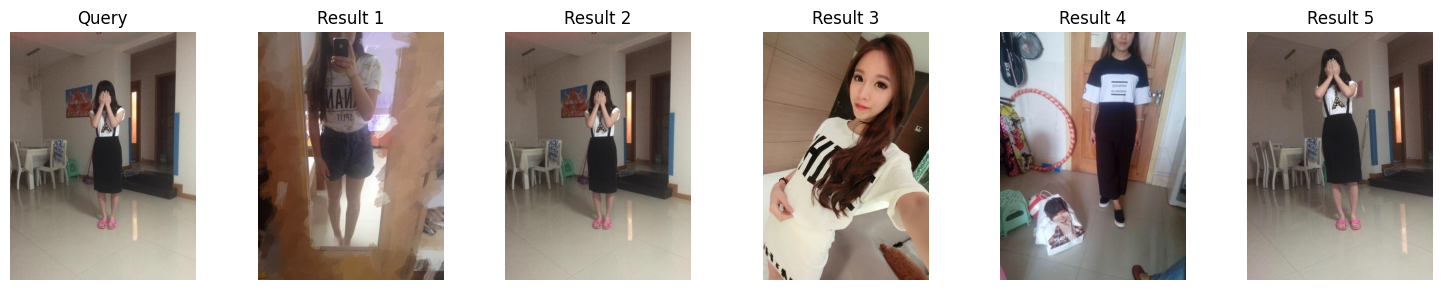

In [170]:
# --- FAST reload ---
index = faiss.read_index("val_gallery.index")

import pickle, gzip
with gzip.open("gallery_meta.pkl.gz", "rb") as f:
    image_paths, labels = pickle.load(f)

# pick any query image from gallery
query_path = image_paths[0]  # or any index like image_paths[400]

# run retrieval based on predicted category
result_paths = retrieve_similar(query_path,
                                index, image_paths, labels,
                                annos_folder, model, transform,
                                id_to_name=id_to_name,
                                top_k=5)

# show the query and top-k matches
visualize_results(query_path, result_paths)



🔎  Query predicted category → Trousers
⚠️ No gallery items in predicted category — falling back to full search.


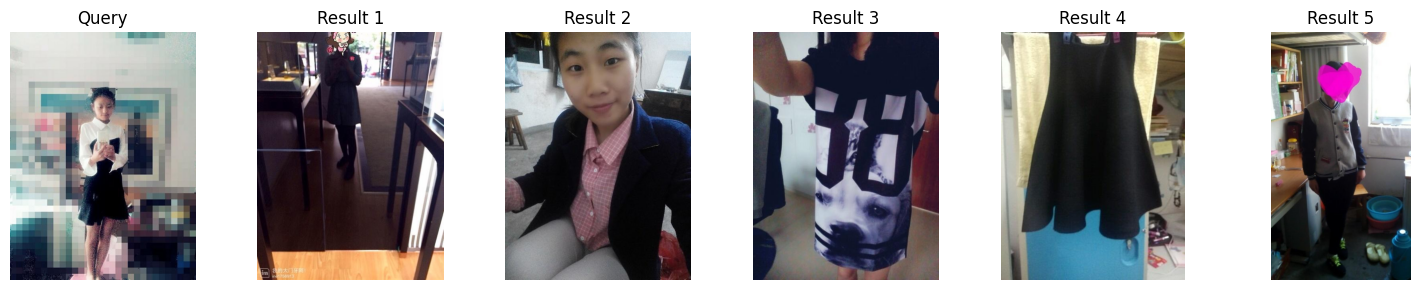

In [171]:
# --- FAST reload ---
index = faiss.read_index("val_gallery.index")

import pickle, gzip
with gzip.open("gallery_meta.pkl.gz", "rb") as f:
    image_paths, labels = pickle.load(f)

# pick any query image from gallery
query_path = image_paths[400]  # or any index like image_paths[400]

# run retrieval based on predicted category
result_paths = retrieve_similar(query_path,
                                index, image_paths, labels,
                                annos_folder, model, transform,
                                id_to_name=id_to_name,
                                top_k=5)

# show the query and top-k matches
visualize_results(query_path, result_paths)



🔎  Query predicted category → Short sleeve top
⚠️ No gallery items in predicted category — falling back to full search.


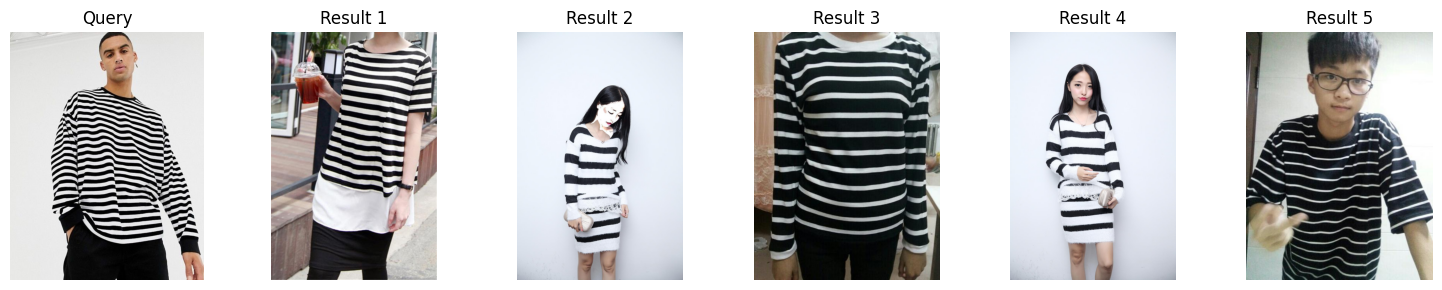

In [172]:
# --- FAST reload ---
index = faiss.read_index("val_gallery.index")

import pickle, gzip
with gzip.open("gallery_meta.pkl.gz", "rb") as f:
    image_paths, labels = pickle.load(f)

# pick any query image from gallery
query_path = "TestingImage.jpg"  # or any index like image_paths[400]

# run retrieval based on predicted category
result_paths = retrieve_similar(query_path,
                                index, image_paths, labels,
                                annos_folder, model, transform,
                                id_to_name=id_to_name,
                                top_k=5)

# show the query and top-k matches
visualize_results(query_path, result_paths)


🔎  Query predicted category → Long sleeve top
⚠️ No gallery items in predicted category — falling back to full search.


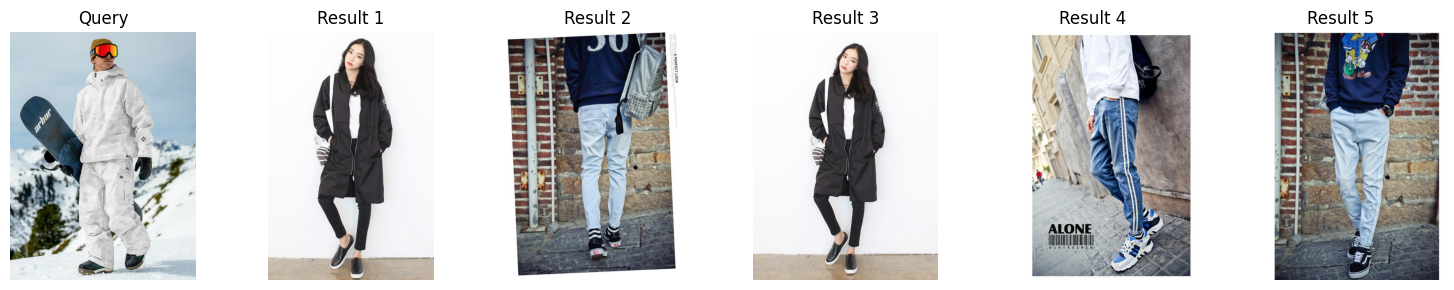

In [173]:
# --- FAST reload ---
index = faiss.read_index("val_gallery.index")

import pickle, gzip
with gzip.open("gallery_meta.pkl.gz", "rb") as f:
    image_paths, labels = pickle.load(f)

# pick any query image from gallery
query_path = "TestingImage3.jpg"  # or any index like image_paths[400]

# run retrieval based on predicted category
result_paths = retrieve_similar(query_path,
                                index, image_paths, labels,
                                annos_folder, model, transform,
                                id_to_name=id_to_name,
                                top_k=5)

# show the query and top-k matches
visualize_results(query_path, result_paths)


🔎  Query predicted category → Short sleeve top
⚠️ No gallery items in predicted category — falling back to full search.


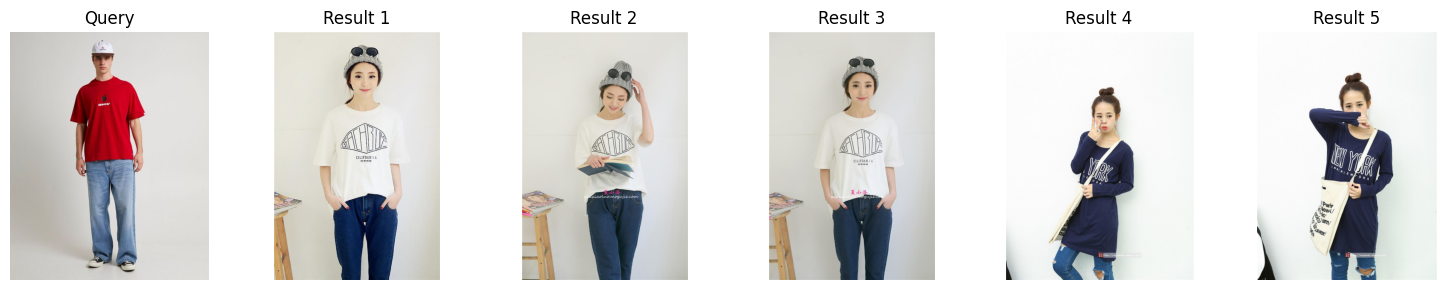

In [174]:
# --- FAST reload ---
index = faiss.read_index("val_gallery.index")

import pickle, gzip
with gzip.open("gallery_meta.pkl.gz", "rb") as f:
    image_paths, labels = pickle.load(f)

# pick any query image from gallery
query_path = "TestingImage2.jpg"  # or any index like image_paths[400]

# run retrieval based on predicted category
result_paths = retrieve_similar(query_path,
                                index, image_paths, labels,
                                annos_folder, model, transform,
                                id_to_name=id_to_name,
                                top_k=5)

# show the query and top-k matches
visualize_results(query_path, result_paths)

